# xylE dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh')

import mavenn
import logomaker
import seaborn as sns
import re
import urllib

#%matplotlib inline

# Summary 

The *xylE* sort-seq MPRA data of Belliveau et. al., 2018. The authors used fluoresence-activated cell sorting, followed by deep sequencing, to assay gene expression levels from the the *xylE* promoter in *E. coli*. *xylE* is a xylose/proton symporter involved in uptake of xylose. Note that the authors also performed several different experiments at multiple other *E. Coli* promoters, but this notebook is restricted to *xylE*. See Belliveau et al., 2018 for more details.

The authors performed their experiment by splitting the *xylE* promoter into three regions, where the subsequences of the *xylE* promoter were mutagenized. The authors subsequently FACS sorted these variant sequences from each region into 1 of 4 bins. Thus, each of the 3 regions was sorted into 4 bins, and each sequence is associated with counts in 4 of 12 total bins. This notebook takes the variant promoter sequences in each of the mutagenized regions and forms a full 150 bp xylE promoter sequence by putting the consensus sequence outside of the window where the sequences were mutagenized.

In the following three (raw) dataframes (corresponding to the 3 mutagenized *xylE* regions), the `'x'` column lists variant sequences, and the `'bin'` column  lists the number of read counts for each sequence (observed in 1 of 4 FACS bins). Each of the sequences in the raw dataframes have a value less than the full length of 150 bp. The final dataframe will have full 150 bp length sequences and their associated counts. The `'set'` column in final_df indicates whether each sequence is to assigned to the training set, the validation set, or the test set.

**Names**: ``'xylE'``

**Reference**: Nathan M Belliveau, Stephanie L Barnes, William T Ireland, Daniel L Jones, Michael J Sweredoski, Annie Moradian, Sonja Hess, Justin B Kinney, Rob Phillips. Systematic approach for dissecting the molecular mechanisms of transcriptional regulation in bacteria. [Proc Natl Acad Sci USA, 115, E4796–E4805 (2018).](https://doi.org/10.1073/pnas.1722055115)

# Download raw data
The following cell downloads each of the mutagenized regions into 3 pandas dataframes. Note that the urls will have to be updated to replace development to master after mavenn has been released to PyPI.

In [2]:
# Download 3 mutagenized regions of datset into pandas dataframes

# region 1 (library 1)
file_name = '20160710_xylE_MG1655_M9xylose_na_mut1_4bins_pymc.csv.gz'
url = f'https://github.com/jbkinney/mavenn/blob/development/mavenn/examples/datasets/raw/{file_name}?raw=true'

data_df_mut1 = pd.read_csv(url,  
                           compression='gzip',
                           index_col=[0])

# region 2 (library 2)
file_name = '20160710_xylE_MG1655_M9xylose_na_mut2_4bins_pymc.csv.gz'
url = f'https://github.com/jbkinney/mavenn/blob/development/mavenn/examples/datasets/raw/{file_name}?raw=true'

data_df_mut2 = pd.read_csv(url,  
                           compression='gzip',
                           index_col=[0])


# region 3 (library 3)
file_name = '20160710_xylE_MG1655_M9xylose_na_mut3_4bins_pymc.csv.gz'
url = f'https://github.com/jbkinney/mavenn/blob/development/mavenn/examples/datasets/raw/{file_name}?raw=true'

data_df_mut3 = pd.read_csv(url,  
                           compression='gzip',
                           index_col=[0])

/Users/tareen/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Escherichia coli str. K-12 substr. MG1655, complete genome donwloaded from: https://www.ncbi.nlm.nih.gov/nuccore/U00096.3?report=fasta

In [3]:
# read the E. Coli
with open('e_coli_genome.fasta') as f:
    raw_ecoli_genome = f.readlines()    

In [4]:
# preview the E. Coli genome
raw_ecoli_genome[0:5]

['>U00096.3 Escherichia coli str. K-12 substr. MG1655, complete genome\n',
 'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGC\n',
 'TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAA\n',
 'TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACC\n',
 'ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAG\n']

In [5]:
# remove >'s and newline characters
genome = [line.strip() for line in raw_ecoli_genome if ('>') not in line]

In [6]:
# preview the genome
genome[0:5]

['AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGC',
 'TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAA',
 'TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACC',
 'ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAG',
 'CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAACAACCATGCGAGTGTTGAA']

We note that the absolute Position of Transcription Start Site: **4242291** base pairs (https://biocyc.org/ECOLI/NEW-IMAGE?type=OPERON-IN-CHROM-BROWSER&object=TU0-14113&chromosome=COLI-K12)

We use this number to determine which index of the genome list variable corresponding to WT sequence in our region of interest.

In [7]:
int(4242291/(len(genome[0])))

60604

Since the entire promoter region mutagenized in the assay was 150 bp (greater than the length of the single sequence stored in the genome variable), we should look +/- 1 index around the line index 60605 to ensure we get the correct sequence. Thus our WT sequence of interest is given by the following sub-sequence from the E. Coli genome

In [8]:
print(genome[60603])
print(genome[60604])
print(genome[60605])

AAGGTAATCGAAAATATATAACTGGAATTATACTGGGTATTCATTCAGACCTGCCTTAGACCATTCTGAT
CTTTTATCAGTGCATTGATGTTGGAATTGTCAGGCAGTTAAGGCAATTATCATTTTTTACAATGCGTTTA
CGTAATGTCTTTTCTGTGATCTTAATTGTGATAATTATCCAAAATTGATAAAAACAATACTATTGCCGTG


## Verification of E. Coli genomic region location

To double check whether we have the correct region of the E. Coli, we can do the following simple test: we can construct a consensus sequence from our variant promoter sequences; if we have the correct genomic region, then that consensus sequence should match the genomic region. 

In [9]:
# the following snippet shows how these probability matrices were generated
prob_mat_mut_3 = logomaker.alignment_to_matrix(sequences=data_df_mut3['x'].values,to_type='probability')
prob_mat_mut_2 = logomaker.alignment_to_matrix(sequences=data_df_mut2['x'].values,to_type='probability')
prob_mat_mut_1 = logomaker.alignment_to_matrix(sequences=data_df_mut1['x'].values,to_type='probability')


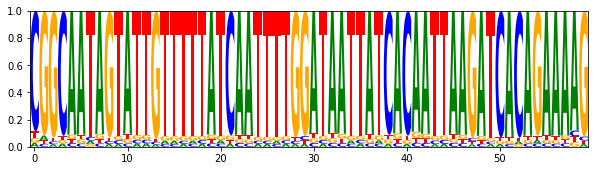

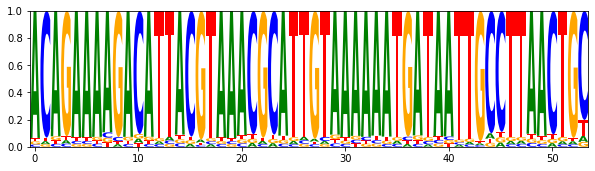

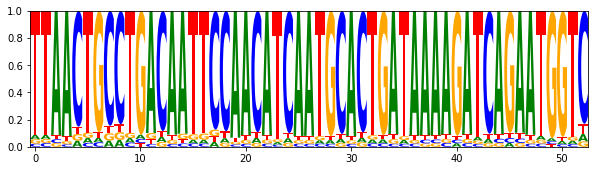

In [10]:
# We will use these probability matrices to construct a consensus
# from data and match to the WT sequence from the E. Coli genome.
logo_mut_3 = logomaker.Logo(prob_mat_mut_3)
logo_mut_2 = logomaker.Logo(prob_mat_mut_2)
logo_mut_1 = logomaker.Logo(prob_mat_mut_1)

The following logos visualize the consensus sequences in each of the 3 libraries. The yellow highlighted regions will help with the formation of the consensus sequence string 2 cells below.

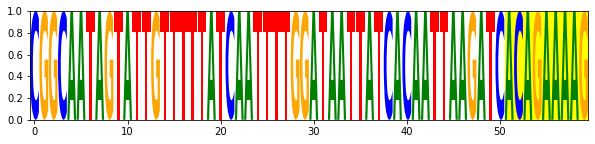

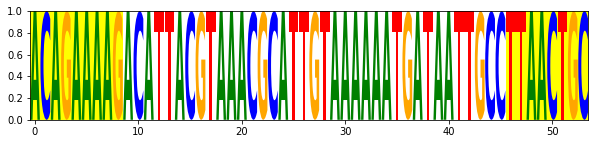

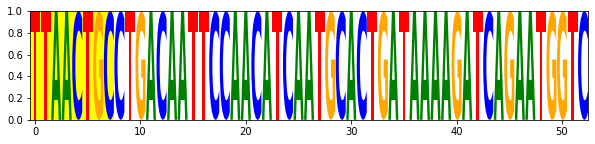

In [11]:
cons_seq_mut_3, _ = mavenn.src.utils.vec_data_to_mat_data(np.argmax(logo_mut_3.df.values,axis=1))
cons_mut_3_logo = logomaker.Logo(pd.DataFrame(cons_seq_mut_3,columns=['A','C','G','T']),figsize=(10,2))
cons_mut_3_logo.highlight_position_range(51,59)


cons_seq_mut_2, _ = mavenn.src.utils.vec_data_to_mat_data(np.argmax(logo_mut_2.df.values,axis=1))
cons_mut_2_logo = logomaker.Logo(pd.DataFrame(cons_seq_mut_2,columns=['A','C','G','T']),figsize=(10,2))
cons_mut_2_logo.highlight_position_range(0,8)
cons_mut_2_logo.highlight_position_range(46,53)

# one is closest to xylE gene (left most)
cons_seq_mut_1, _ = mavenn.src.utils.vec_data_to_mat_data(np.argmax(logo_mut_1.df.values,axis=1))
cons_mut_1_logo = logomaker.Logo(pd.DataFrame(cons_seq_mut_1,columns=['A','C','G','T']),figsize=(10,2))
cons_mut_1_logo.highlight_position_range(0,7)


Form consensues sequence string

In [12]:

bp_dict = {0:'A',1:'C',2:'G',3:'T'}
cons_mut_3 = ''
cons_mut_2 = ''
cons_mut_1 = ''

for idx,value in cons_mut_3_logo.df.iterrows():
    cons_mut_3+=bp_dict[np.argmax(value)]

for idx,value in cons_mut_2_logo.df.iterrows():
    cons_mut_2+=bp_dict[np.argmax(value)]

for idx,value in cons_mut_1_logo.df.iterrows():
    cons_mut_1+=bp_dict[np.argmax(value)]


# The full consensus sequence is as follows and is 150 bp in length. 
# Note that the values of indices 9:46 were obtained by looking at 
# the highlighted areas in the consensus logos above    
consensus_seq_from_data = cons_mut_3+cons_mut_2[9:46]+cons_mut_1 

In [13]:
# method to reverse complement sequences
def reverse_complement(seq):
    complement = str.maketrans('ATCGN', 'TAGCN')
    return str(seq).upper().translate(complement)[::-1]

consensus_seq_from_data_rc = reverse_complement(consensus_seq_from_data)

In [14]:
print(consensus_seq_from_data,'\n') 
print(consensus_seq_from_data_rc)

CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTAAGATCACAGAAAAGACATTACGTAAACGCATTGTAAAAAATGATAATTGCCTTAACTGCCTGACAATTCCAACATCAATGCACTGATAAAAGATCAGAATGGTC 

GACCATTCTGATCTTTTATCAGTGCATTGATGTTGGAATTGTCAGGCAGTTAAGGCAATTATCATTTTTTACAATGCGTTTACGTAATGTCTTTTCTGTGATCTTAATTGTGATAATTATCCAAAATTGATAAAAACAATACTATTGCCG


Now that we have the consensus sequence from data, we can match to the WT sequence that we obtained from the E. Coli genome

In [15]:
print('Consensus sequences from data matches xylE location in E. Coli genome: ',consensus_seq_from_data in genome[60603]+genome[60604]+genome[60605])
print('Consensus sequences from data matches xylE location in E. Coli genome: ',consensus_seq_from_data_rc in genome[60603]+genome[60604]+genome[60605])


Consensus sequences from data matches xylE location in E. Coli genome:  False
Consensus sequences from data matches xylE location in E. Coli genome:  True


We note that the reverse complement of the consensus sequence matches the xylE gene location exactly. We can now construct full length sequences using the reverse complement of the xylE WT sequence from the genome.

In [16]:
genome[60603]+genome[60604]+genome[60605]

'AAGGTAATCGAAAATATATAACTGGAATTATACTGGGTATTCATTCAGACCTGCCTTAGACCATTCTGATCTTTTATCAGTGCATTGATGTTGGAATTGTCAGGCAGTTAAGGCAATTATCATTTTTTACAATGCGTTTACGTAATGTCTTTTCTGTGATCTTAATTGTGATAATTATCCAAAATTGATAAAAACAATACTATTGCCGTG'

The above string is 210 bp long. The exact 150 bp sequence can be found by matching the sequence of the xylE promoter provided on https://biocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU0-14113

In [17]:
WT_sequence = reverse_complement(genome[60603]+genome[60604]+genome[60605])[2:152]

In [18]:
# We can also check whether this WT sequence matches our consensus from data 
WT_sequence == consensus_seq_from_data

True

# Form full length sequences

Since the sequences in library 3 are 60 bp in length, the full length sequences for library will be `data_df_mut3['x'] + WT_sequence[60:]`

In [19]:
WT_sequence[60:]

'ACATTACGTAAACGCATTGTAAAAAATGATAATTGCCTTAACTGCCTGACAATTCCAACATCAATGCACTGATAAAAGATCAGAATGGTC'

In [20]:
# full library_3_sequences 
data_df_mut3['x_full'] = data_df_mut3.x+WT_sequence[60:]
data_df_mut3.head()

,x,bin,x_full
0,CAGCAATAGCATTATTTTTATCAATTTTGGATAATTATCACAATTA...,0,CAGCAATAGCATTATTTTTATCAATTTTGGATAATTATCACAATTA...
1,CGGCAATAGTATTGTTTATATCGATTTTGGATAGTTATCTCAATTA...,0,CGGCAATAGTATTGTTTATATCGATTTTGGATAGTTATCTCAATTA...
2,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...
3,TGGCAATATTATTGTTTTTGTCAATTTTGGATAATTATCACAATTA...,0,TGGCAATATTATTGTTTTTGTCAATTTTGGATAATTATCACAATTA...
4,GGGCATTAATATGTTTTTTACCAATTTTGGATTATTATCCCAATTA...,0,GGGCATTAATATGTTTTTTACCAATTTTGGATTATTATCCCAATTA...


In [21]:
data_df_mut2.head()

,x,bin
0,ACAGAAAAGACATAACGTAAACGCATTGTAAAAAATGATAGTTGCC...,0
1,ACAGAAAAGACATTACGTCAACGCATTGTTAAAATTGATTAATTCC...,0
2,ACAGAAAAGACATTACGTTAACGAATTGTAAAGAAGGATAATAGCC...,0
3,ACAGAAAAGACATTACGTAAACGCATTGTTAAAGATGAAAAATAAC...,0
4,ACAGAAAAGACATTACGTAAACGCATTGTAAAAAATGGTAACTGCC...,0


The sequences in library 2 are in the middle of the promoter, and by looking at the logos above, they will be form as `WT_sequence[0:50]+data_df_mut2.x+WT_sequence[104:]`

In [22]:
data_df_mut2['x_full'] = WT_sequence[0:50]+data_df_mut2.x+WT_sequence[104:]

In [23]:
data_df_mut2.head()

,x,bin,x_full
0,ACAGAAAAGACATAACGTAAACGCATTGTAAAAAATGATAGTTGCC...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...
1,ACAGAAAAGACATTACGTCAACGCATTGTTAAAATTGATTAATTCC...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...
2,ACAGAAAAGACATTACGTTAACGAATTGTAAAGAAGGATAATAGCC...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...
3,ACAGAAAAGACATTACGTAAACGCATTGTTAAAGATGAAAAATAAC...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...
4,ACAGAAAAGACATTACGTAAACGCATTGTAAAAAATGGTAACTGCC...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...


Finally, the length of sequences in library 1 is 53, so the full sequences will be `WT_sequence[0:97]+data_df_mut1.x`, where the 93 is from 150 - 53

In [24]:
data_df_mut1['x_full'] = WT_sequence[0:97]+data_df_mut1.x

In [25]:
data_df_mut1.head()

,x,bin,x_full
0,TTAACTGTCTGACGATTCAAACATCAATACACTAATAAAAGATCAG...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...
1,TTAACTGCATGACAATTCCAACCTCAATGCATTGATAAAAGATCAG...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...
2,TTAACTGCCTGACAATTCCAAGATCAATGCAGTGATAAAGGATCAG...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...
3,TTTACTGCGTGTCAATTCGGGCAGCAGTACACTTATAAGAGATCAG...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...
4,TAAACTACCTGACAACTCCAACTTTAACGCACTGATTACAGTTCAG...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...


Transform vector format bin data into matrix from data using mavenn's vec_data_to_mat_data utility function

In [26]:
cts_mut_1 = mavenn.src.utils.vec_data_to_mat_data(data_df_mut1['bin'].values)
cts_mut_2 = mavenn.src.utils.vec_data_to_mat_data(data_df_mut2['bin'].values)
cts_mut_3 = mavenn.src.utils.vec_data_to_mat_data(data_df_mut3['bin'].values)

In [27]:
# this what the transform counts matrix data looks like from region 1. 
cts_mut_1

(array([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1]]),
 array([      0,       1,       2, ..., 2897334, 2897335, 2897336]))

In [28]:
# form counts dataframes
cts_mut_3_df = pd.DataFrame(cts_mut_3[0],columns=['ct_0','ct_1','ct_2','ct_3'])
cts_mut_2_df = pd.DataFrame(cts_mut_2[0],columns=['ct_4','ct_5','ct_6','ct_7'])
cts_mut_1_df = pd.DataFrame(cts_mut_1[0],columns=['ct_8','ct_9','ct_10','ct_11'])


Initially, the counts dataframe for library 3 looks like the following matrix, with only four columns. Columns ct_4 through ct_11 will be append to this containing all zeros

In [29]:
cts_mut_3_df.head()

,ct_0,ct_1,ct_2,ct_3
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


The updated counts dataframe looks like

In [30]:
# Add bins ct_4 through ct_11 containing all 0 counts
cts_mut_3_df[['ct_4','ct_5','ct_6','ct_7','ct_8','ct_9','ct_10','ct_11']] = [0,0,0,0,0,0,0,0]
cts_mut_3_df.head(10)

,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,ct_10,ct_11
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0


Now do the same thing for libraries 2 and 1, respectively.

In [31]:
cts_mut_2_df.insert(0,'ct_0',0)
cts_mut_2_df.insert(1,'ct_1',0)
cts_mut_2_df.insert(2,'ct_2',0)
cts_mut_2_df.insert(3,'ct_3',0)
cts_mut_2_df[['ct_8','ct_9','ct_10','ct_11']] = [0,0,0,0]

In [32]:
cts_mut_2_df.head()

,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,ct_10,ct_11
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0


In [33]:
for idx in range(8):
    cts_mut_1_df.insert(idx,f'ct_{idx}',0)
cts_mut_1_df.head()    

,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,ct_10,ct_11
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0


Now merge the sequence dataframe and their associated counts dataframes together

In [34]:
data_df_mut1 = data_df_mut1.merge(cts_mut_1_df,how='outer', left_index=True, right_index=True)
data_df_mut2 = data_df_mut2.merge(cts_mut_2_df,how='outer', left_index=True, right_index=True)
data_df_mut3 = data_df_mut3.merge(cts_mut_3_df,how='outer', left_index=True, right_index=True)

Finally, put together the dataframe of all sequences and their associated counts

In [35]:
data_df = pd.concat([data_df_mut3, data_df_mut2, data_df_mut1],ignore_index=True)

The combined dataset is shown below

In [36]:
data_df

,x,bin,x_full,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,ct_10,ct_11
0,CAGCAATAGCATTATTTTTATCAATTTTGGATAATTATCACAATTA...,0,CAGCAATAGCATTATTTTTATCAATTTTGGATAATTATCACAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
1,CGGCAATAGTATTGTTTATATCGATTTTGGATAGTTATCTCAATTA...,0,CGGCAATAGTATTGTTTATATCGATTTTGGATAGTTATCTCAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
2,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
3,TGGCAATATTATTGTTTTTGTCAATTTTGGATAATTATCACAATTA...,0,TGGCAATATTATTGTTTTTGTCAATTTTGGATAATTATCACAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
4,GGGCATTAATATGTTTTTTACCAATTTTGGATTATTATCCCAATTA...,0,GGGCATTAATATGTTTTTTACCAATTTTGGATTATTATCCCAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859154,TTAACAGCCCGTCAATTCTAACATCAATGCACTCATAAAAGATCAG...,3,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1
6859155,TTAACTGCTTGAAAATGCCAACATCAATGCACTGATAAAAGATCAG...,3,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1
6859156,TTAACTGCCTGACAATTCCAACATCAATGCACTGATAAAAGATCAG...,3,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1
6859157,TTAACTGTCTTACAATTCCAACATCAATGCACTGATAAAAGATCAG...,3,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1


In [37]:
# do some clean of dataframe
del data_df['x']
del data_df['bin']

In [38]:
# rename x_full to x
data_df.rename(columns={'x_full':'x'}, inplace=True)

This dataframe now only contains counts across all 12 bins.

In [39]:
data_df

,x,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,ct_10,ct_11
0,CAGCAATAGCATTATTTTTATCAATTTTGGATAATTATCACAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
1,CGGCAATAGTATTGTTTATATCGATTTTGGATAGTTATCTCAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
2,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
3,TGGCAATATTATTGTTTTTGTCAATTTTGGATAATTATCACAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
4,GGGCATTAATATGTTTTTTACCAATTTTGGATTATTATCCCAATTA...,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859154,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1
6859155,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1
6859156,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1
6859157,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1


In [40]:
# Randomly assign sequences to training, validation, and test sets
final_df = data_df.copy()
np.random.seed(0)
final_df['set'] = np.random.choice(a=['training','test','validation'], 
                                   p=[.6,.2,.2], 
                                   size=len(final_df))

The final dataset

In [41]:
final_df 

,x,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,ct_10,ct_11,set
0,CAGCAATAGCATTATTTTTATCAATTTTGGATAATTATCACAATTA...,1,0,0,0,0,0,0,0,0,0,0,0,training
1,CGGCAATAGTATTGTTTATATCGATTTTGGATAGTTATCTCAATTA...,1,0,0,0,0,0,0,0,0,0,0,0,test
2,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,1,0,0,0,0,0,0,0,0,0,0,0,test
3,TGGCAATATTATTGTTTTTGTCAATTTTGGATAATTATCACAATTA...,1,0,0,0,0,0,0,0,0,0,0,0,training
4,GGGCATTAATATGTTTTTTACCAATTTTGGATTATTATCCCAATTA...,1,0,0,0,0,0,0,0,0,0,0,0,training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859154,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1,test
6859155,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1,validation
6859156,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1,training
6859157,CGGCAATAGTATTGTTTTTATCAATTTTGGATAATTATCACAATTA...,0,0,0,0,0,0,0,0,0,0,0,1,validation


In [42]:
# save data
final_df.to_csv('xylE_data.csv.gz',index=False, compression='gzip')